In [1]:


import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [5]:
df_beta.shape

(10, 36511)

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = ['gene_'+str(x) for x in range(len(dl.genes))]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

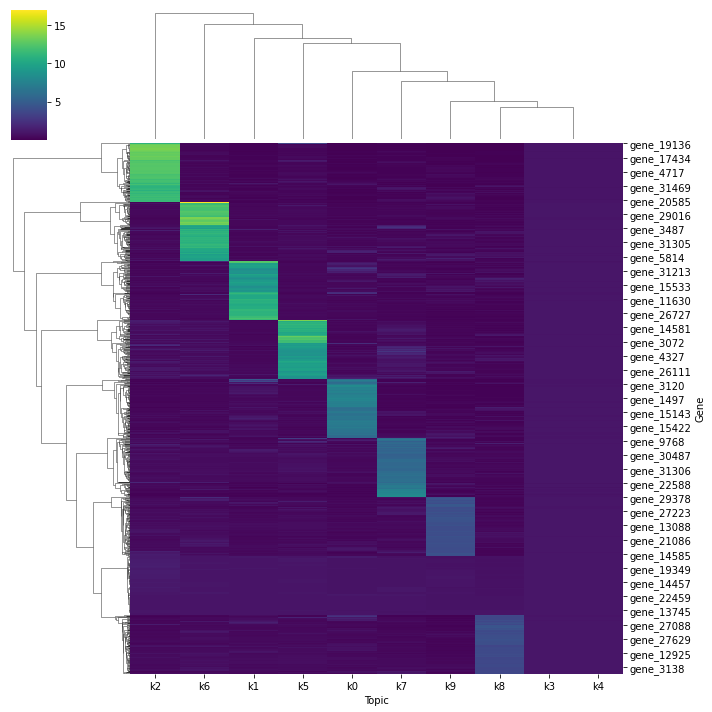

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1_3k,1,9.072317,10.486408
1,AAACATTGAGCTAC-1_3k,6,-4.090335,-6.059144
2,AAACATTGATCAGC-1_3k,5,12.629378,11.048252
3,AAACCGTGCTTCCG-1_3k,7,3.492803,-0.146543
4,AAACCGTGTATGCG-1_3k,3,-3.401514,9.345277
...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k,2,0.834477,-0.767159
7036,TTTGTCACACTTAACG-1_4k,9,12.512808,14.282797
7037,TTTGTCACAGGTCCAC-1_4k,5,10.245297,12.906226
7038,TTTGTCAGTTAAGACA-1_4k,6,-3.509805,-8.292161


Text(0, 0.5, 'UMAP2')

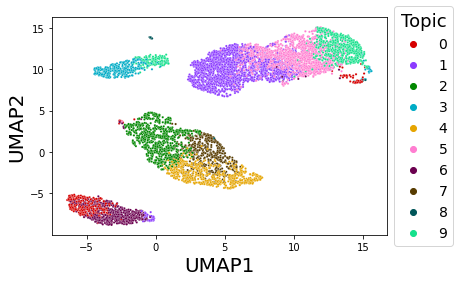

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

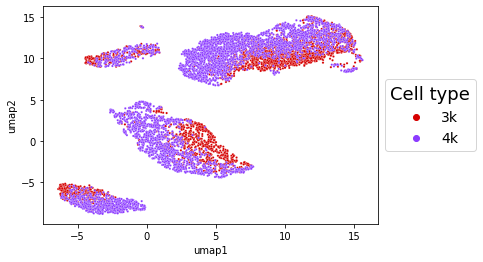

In [7]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [33]:
df_umap = df_umap.drop(columns=['cell_type_y'])
df_umap

,cell,topic_bulk,umap1,umap2,batch
0,AAACATACAACCAC-1,0,6.266104,10.222329,3k
1,AAACATTGAGCTAC-1,0,11.398894,0.340405,3k
2,AAACATTGATCAGC-1,0,10.004198,11.123991,3k
3,AAACCGTGCTTCCG-1,0,-0.226316,-3.855952,3k
4,AAACCGTGTATGCG-1,0,10.862628,4.713277,3k
...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,0,0.496337,-3.800373,4k
7036,TTTGTCACACTTAACG-1,0,9.481683,8.888184,4k
7037,TTTGTCACAGGTCCAC-1,0,6.041478,10.670822,4k
7038,TTTGTCAGTTAAGACA-1,0,11.815601,-2.299423,4k


In [8]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,1,9.072317,10.486408,3k,0
1,AAACATTGAGCTAC-1,6,-4.090335,-6.059144,3k,2
2,AAACATTGATCAGC-1,5,12.629378,11.048252,3k,1
3,AAACCGTGCTTCCG-1,7,3.492803,-0.146543,3k,5
4,AAACCGTGTATGCG-1,3,-3.401514,9.345277,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,2,0.834477,-0.767159,4k,3
7036,TTTGTCACACTTAACG-1,9,12.512808,14.282797,4k,6
7037,TTTGTCACAGGTCCAC-1,5,10.245297,12.906226,4k,6
7038,TTTGTCAGTTAAGACA-1,6,-3.509805,-8.292161,4k,2


In [11]:
df_umap=df_umap.fillna(100)
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,0,6.266104,10.222329,3k,0.0
1,AAACATTGAGCTAC-1,0,11.398894,0.340405,3k,3.0
2,AAACATTGATCAGC-1,0,10.004198,11.123991,3k,0.0
3,AAACCGTGCTTCCG-1,0,-0.226316,-3.855952,3k,1.0
4,AAACCGTGTATGCG-1,0,10.862628,4.713277,3k,2.0
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,0,0.496337,-3.800373,4k,100.0
7036,TTTGTCACACTTAACG-1,0,9.481683,8.888184,4k,100.0
7037,TTTGTCACAGGTCCAC-1,0,6.041478,10.670822,4k,100.0
7038,TTTGTCAGTTAAGACA-1,0,11.815601,-2.299423,4k,100.0


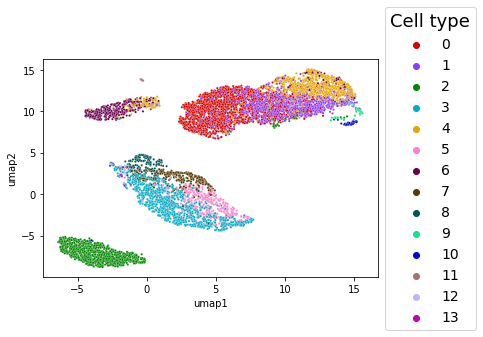

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                          \
topic_bulk      0       1      2      3      4      5      6      7     8   
cell_type                                                                   
0             0.0  1347.0    0.0    0.0    0.0  388.0    1.0    0.0   0.0   
1             3.0   367.0    1.0    6.0    0.0  608.0    1.0    0.0   0.0   
2           272.0    52.0    0.0    0.0    0.0   16.0  621.0    0.0   0.0   
3             0.0     0.0  398.0    0.0  470.0    0.0    8.0    8.0   0.0   
4             1.0    39.0    0.0   26.0    0.0  363.0    0.0    0.0   0.0   
5             0.0     0.0   29.0    0.0  119.0    0.0    0.0  336.0   0.0   
6             0.0     0.0    1.0  275.0    0.0    9.0    0.0    0.0   0.0   
7             0.0     0.0  145.0    0.0    0.0    0.0    3.0  145.0   0.0   
8             2.0     0.0  141.0    0.0    3.0    0.0    0.0    5.0   0.0   
9            14.0     0.0    0.0   16.0    0.0    0.0    3.0    0.0   0.0   
10           30.0     0.0    2.0    7.0    0.0    0.0    0.0    0.0   2.0   
11            1.0     0.0    8.0    1.0    3.0    0.0    0.0    0.0  16.0   
12            2.0     0.0   14.0    0.0    2.0    0.0    2.0    0.0   0.0   
13            0.0     0.0   14.0    0.0    0.0    0.0    0.0    0.0   0.0   

                   
topic_bulk      9  
cell_type          
0            17.0  
1           130.0  
2             4.0  
3             0.0  
4           448.0  
5             0.0  
6            85.0  
7             0.0  
8             0.0  
9            10.0  
10            0.0  
11            0.0  
12            0.0  
13            0.0

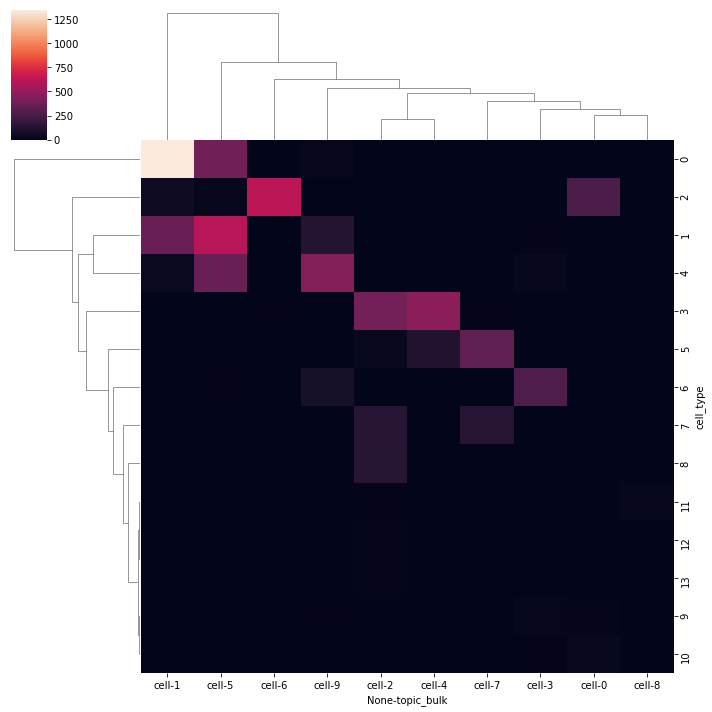

In [11]:
sns.clustermap(df_match)

In [50]:
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,2,6.266104,10.222329,3k,0
1,AAACATTGAGCTAC-1,4,11.398894,0.340405,3k,2
2,AAACATTGATCAGC-1,2,10.004198,11.123991,3k,1
3,AAACCGTGCTTCCG-1,8,-0.226316,-3.855952,3k,5
4,AAACCGTGTATGCG-1,3,10.862628,4.713277,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,6,0.496337,-3.800373,4k,3
7036,TTTGTCACACTTAACG-1,5,9.481683,8.888184,4k,6
7037,TTTGTCACAGGTCCAC-1,2,6.041478,10.670822,4k,6
7038,TTTGTCAGTTAAGACA-1,4,11.815601,-2.299423,4k,2


In [12]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.6082426461622266